In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

from scipy import integrate
import numpy as np
from matplotlib import pyplot as plt
import arrayfire as af
af.set_backend('cpu')

from dg_maxwell import lagrange
from dg_maxwell import isoparam
from dg_maxwell import wave_equation
from dg_maxwell import params
from dg_maxwell import utils

plt.rcParams['figure.figsize']     = 12, 7.5
plt.rcParams['lines.linewidth']    = 1.5
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.weight']        = 'bold'
plt.rcParams['font.size']          = 20  
plt.rcParams['font.sans-serif']    = 'serif'
plt.rcParams['text.usetex']        = True
plt.rcParams['axes.linewidth']     = 1.5
plt.rcParams['axes.titlesize']     = 'medium'
plt.rcParams['axes.labelsize']     = 'medium'

plt.rcParams['xtick.major.size']   = 8
plt.rcParams['xtick.minor.size']   = 4
plt.rcParams['xtick.major.pad']    = 8
plt.rcParams['xtick.minor.pad']    = 8
plt.rcParams['xtick.color']        = 'k'
plt.rcParams['xtick.labelsize']    = 'medium'
plt.rcParams['xtick.direction']    = 'in'    

plt.rcParams['ytick.major.size']   = 8
plt.rcParams['ytick.minor.size']   = 4
plt.rcParams['ytick.major.pad']    = 8
plt.rcParams['ytick.minor.pad']    = 8
plt.rcParams['ytick.color']        = 'k'
plt.rcParams['ytick.labelsize']    = 'medium'
plt.rcParams['ytick.direction']    = 'in'
plt.rcParams['text.usetex']        = True
plt.rcParams['text.latex.unicode'] = True

In [2]:
def find_L1_norm(epsilon, dx_dxi, x):
    '''
    '''
    lagrange_basis, temp = lagrange.lagrange_polynomials(x)
    
    epsilon_interpol = 0.
    for i in np.arange(x.shape[0]):
        epsilon_interpol += lagrange_basis[i] * epsilon[i]
    
    return integrate.quad(epsilon_interpol * dx_dxi, -1, 1)[0]


def integrate_quad(function, order, scheme = 'gauss_legendre'):
    '''
    '''
    if scheme == 'gauss_legendre':
        nodes   = np.array(lagrange.gauss_nodes(order))
        weights = np.array(lagrange.gaussian_weights(order))

    elif scheme == 'gauss_lobatto':
        nodes   = np.array(lagrange.LGL_points(order))
        weights = np.array(lagrange.lobatto_weights(order))
        
    else:
        return

    integral = 0.

    for node, weight in zip(nodes, weights):
        integral += weight * function(node)
    
    return integral

In [3]:
def test_function(x):
    '''
    The test wave function.
    '''
    return np.sin(2 * np.pi * x)

def int_sin2pix_dLdxi(x_nodes, xi_LGL, lagrange_basis_order):
    '''
    '''
    L_i, temp = lagrange.lagrange_polynomials(xi_LGL)
    
    def sin2pix_dLdxi(xi):
        x = (((x_nodes[1] - x_nodes[0]) * xi + (x_nodes[1] + x_nodes[0]))) / 2
        return np.sin(2 * np.pi * x) * L_i[lagrange_basis_order].deriv()(xi)
    
    return integrate.quad(sin2pix_dLdxi, -1, 1)[0]

def int_exp_dLdxi(x_nodes, xi_LGL, lagrange_basis_order):
    '''
    '''
    L_i, temp = lagrange.lagrange_polynomials(xi_LGL)
    
    def exp_dLdxi(xi):
        x = (((x_nodes[1] - x_nodes[0]) * xi + (x_nodes[1] + x_nodes[0]))) / 2
        return np.e ** (-x ** 2 / 0.4 ** 2) * L_i[lagrange_basis_order].deriv()(xi)
    
    return integrate.quad(exp_dLdxi, -1, 1)[0]


In [4]:
def change_parameters(N_LGL = 8, N_Elements = 8, N_quad = 8, wave = 'sin'):
    '''
    '''
    # The domain of the function.
    params.x_nodes    = af.np_to_af_array(np.array([0, 1.]))

    # The number of LGL points into which an element is split.
    params.N_LGL      = N_LGL

    # Number of elements the domain is to be divided into.
    params.N_Elements = N_Elements

    # The number quadrature points to be used for integration.
    params.N_quad     = N_quad

    # Array containing the LGL points in xi space.
    params.xi_LGL     = lagrange.LGL_points(params.N_LGL)

    # N_Gauss number of Gauss nodes.
    params.gauss_points  = af.np_to_af_array(lagrange.gauss_nodes\
                                                    (params.N_quad))

    # The Gaussian weights.
    params.gauss_weights = lagrange.gaussian_weights(params.N_quad)

    # The lobatto nodes to be used for integration.
    params.lobatto_quadrature_nodes   = lagrange.LGL_points(params.N_quad)

    # The lobatto weights to be used for integration.
    params.lobatto_weights_quadrature = lagrange.lobatto_weights\
                                        (params.N_quad)

    # A list of the Lagrange polynomials in poly1d form.
    params.lagrange_product = lagrange.product_lagrange_poly(params.xi_LGL)

    # An array containing the coefficients of the lagrange basis polynomials.
    params.lagrange_coeffs  = af.np_to_af_array(\
                              lagrange.lagrange_polynomials(params.xi_LGL)[1])

    # Refer corresponding functions.
    params.lagrange_basis_value = lagrange.lagrange_function_value\
                                           (params.lagrange_coeffs)

    # A list of the Lagrange polynomials in poly1d form.
    params.lagrange_poly1d_list = lagrange.lagrange_polynomials(params.xi_LGL)[0]


    # list containing the poly1d forms of the differential of Lagrange
    # basis polynomials.
    params.differential_lagrange_polynomial = lagrange.differential_lagrange_poly1d()


    # While evaluating the volume integral using N_LGL
    # lobatto quadrature points, The integration can be vectorized
    # and in this case the coefficients of the differential of the
    # Lagrange polynomials is required
    params.volume_integrand_N_LGL = np.zeros(([params.N_LGL, params.N_LGL - 1]))

    for i in range(params.N_LGL):
        params.volume_integrand_N_LGL[i] = (params.differential_lagrange_polynomial[i]).c

    params.volume_integrand_N_LGL= af.np_to_af_array(params.volume_integrand_N_LGL)

    # Obtaining an array consisting of the LGL points mapped onto the elements.

    params.element_size    = af.sum((params.x_nodes[1] - params.x_nodes[0])\
                                                        / params.N_Elements)
    params.elements_xi_LGL = af.constant(0, params.N_Elements, params.N_LGL)
    params.elements        = utils.linspace(af.sum(params.x_nodes[0]),
                             af.sum(params.x_nodes[1] - params.element_size),\
                                                            params.N_Elements)

    params.np_element_array   = np.concatenate((af.transpose(params.elements),
                                   af.transpose(params.elements +\
                                                       params.element_size)))

    params.element_mesh_nodes = utils.linspace(af.sum(params.x_nodes[0]),
                                        af.sum(params.x_nodes[1]),\
                                               params.N_Elements + 1)

    params.element_array = af.transpose(af.np_to_af_array\
                                       (params.np_element_array))
    params.element_LGL   = wave_equation.mapping_xi_to_x(af.transpose\
                                          (params.element_array), params.xi_LGL)

    # The minimum distance between 2 mapped LGL points.
    params.delta_x = af.min((params.element_LGL - af.shift(params.element_LGL, 1, 0))[1:, :])

    # dx_dxi for elements of equal size.
    params. dx_dxi = af.mean(wave_equation.dx_dxi_numerical((params.element_mesh_nodes[0 : 2]),\
                                   params.xi_LGL))


    # The value of time-step.
    params.delta_t = params.delta_x / (4 * params.c)

    # Array of timesteps seperated by delta_t.
    params.time    = utils.linspace(0, int(params.total_time / params.delta_t) * params.delta_t,
                                                        int(params.total_time / params.delta_t))

    if (wave =='sin'):
        params.u_init     = af.sin(2 * np.pi * params.element_LGL)
        
    if (wave =='gaussian'):
        params.u_init = np.e ** (-(params.element_LGL) ** 2 / 0.4 ** 2)
    
    params.u          = af.constant(0, params.N_LGL, params.N_Elements, params.time.shape[0],\
                                     dtype = af.Dtype.f64)
    params.u[:, :, 0] = params.u_init
                                                     
    return


In [36]:
p = 0
error = []
N_LGL = 8
N_quad = 8

for N_quad in np.arange(3, 31):
    change_parameters(int(N_LGL), N_quad = int(N_quad), wave = 'gaussian')
    volume_integral_flux = wave_equation.volume_integral_flux(params.u_init, 0)
    volume_integral_flux_analytical = np.zeros([params.N_LGL, params.N_Elements])

    for p in np.arange(N_LGL):
        for element_idx, element in enumerate(params.element_array):
            volume_integral_flux_analytical[p][element_idx] = int_exp_dLdxi(np.array(element)[0],
                                                                            params.xi_LGL, p)

    volume_integral_flux_analytical = af.np_to_af_array(volume_integral_flux_analytical)

    error.append(np.array(af.sum(af.abs(volume_integral_flux_analytical - volume_integral_flux), 1))[p])

option3
option3
option3
option3
option3
option1
option3
option3
option3
option3
option3
option3
option3
option3
option3
option3
option3
option3
option3
option3
option3
option3
option3
option3
option3
option3
option3
option3


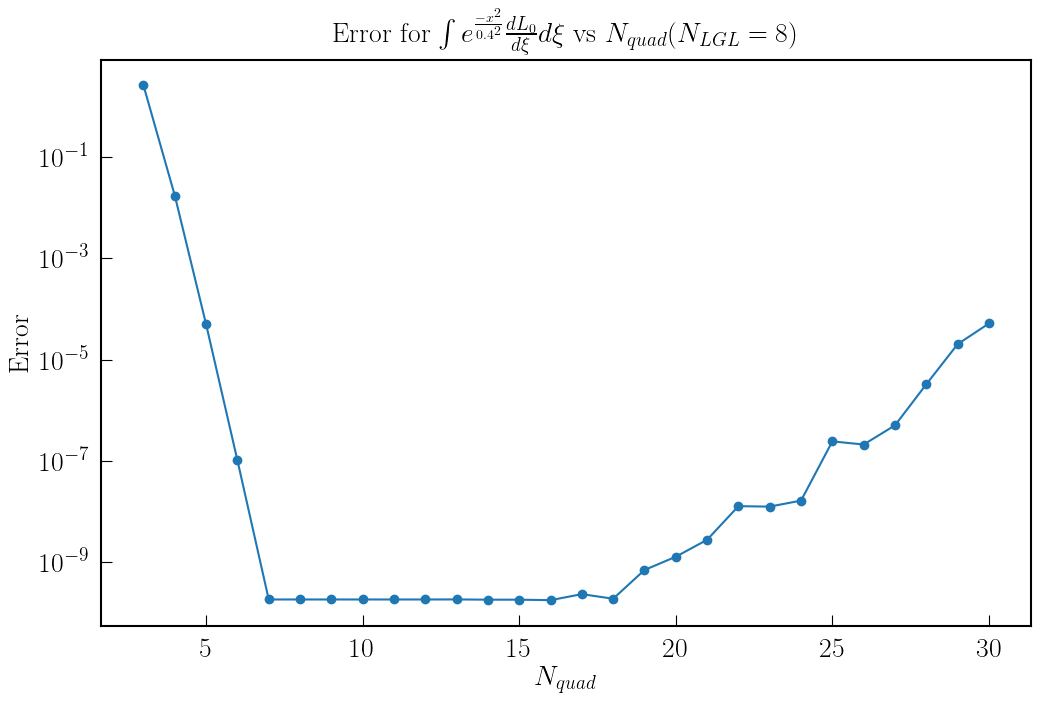

In [37]:
plt.semilogy(np.arange(3, 31), error, '-o')
plt.title(r'Error for $\int e^{\frac{-x^2}{0.4^2}} \frac{d L_0}{d\xi} d\xi$  vs $N_{quad}(N_{LGL} = 8)$')
# plt.title(r'Error for $\int e^{\frac{-x^2}{0.4^2}} \frac{d L_0}{d\xi} d\xi$  vs $N_{LGL} (N_{quad} = 8)$')
# plt.title(r'Error for $\int \sin(2 \pi x) \frac{d L_0}{d\xi} d\xi$  vs $N_{quad}$')
plt.xlabel(r'$N_{quad}$')
plt.ylabel(r'Error')
plt.savefig('error_int_fxi_dLi_dxi.png')
plt.show()

In [45]:
N_LGL = 8
volume_integral_flux_analytical = np.zeros([params.N_LGL, params.N_Elements])

for p in np.arange(N_LGL):
    for element_idx, element in enumerate(params.element_array):
        volume_integral_flux_analytical[p][element_idx] = int_sin2pix_dLdxi(np.array(element)[0],
                                                                            params.xi_LGL, p)

volume_integral_flux_analytical = af.np_to_af_array(volume_integral_flux_analytical)
print(volume_integral_flux_analytical)
    

arrayfire.Array()
Type: double

[8 8 1 1]
   -0.0140    -0.7170    -1.0000    -0.6972     0.0140     0.7170     1.0000     0.6972 
   -0.0826    -0.0555     0.0042     0.0614     0.0826     0.0555    -0.0042    -0.0614 
   -0.1322    -0.0784     0.0214     0.1086     0.1322     0.0784    -0.0214    -0.1086 
   -0.1542    -0.0741     0.0495     0.1440     0.1542     0.0741    -0.0495    -0.1440 
   -0.1440    -0.0495     0.0741     0.1542     0.1440     0.0495    -0.0741    -0.1542 
   -0.1086    -0.0214     0.0784     0.1322     0.1086     0.0214    -0.0784    -0.1322 
   -0.0614    -0.0042     0.0555     0.0826     0.0614     0.0042    -0.0555    -0.0826 
    0.6972     1.0000     0.7170     0.0140    -0.6972    -1.0000    -0.7170    -0.0140 




In [36]:
for element in params.element_array:
    print(element)

arrayfire.Array()
Type: double

[1 2 1 1]
    0.0000     0.1250 

arrayfire.Array()
Type: double

[1 2 1 1]
    0.1250     0.2500 

arrayfire.Array()
Type: double

[1 2 1 1]
    0.2500     0.3750 

arrayfire.Array()
Type: double

[1 2 1 1]
    0.3750     0.5000 

arrayfire.Array()
Type: double

[1 2 1 1]
    0.5000     0.6250 

arrayfire.Array()
Type: double

[1 2 1 1]
    0.6250     0.7500 

arrayfire.Array()
Type: double

[1 2 1 1]
    0.7500     0.8750 

arrayfire.Array()
Type: double

[1 2 1 1]
    0.8750     1.0000 



In [6]:
analytical_integral = 0.
p = 0


int_sin2pix_dLdxi(np.array(params.element_array[0])[0],
                  params.xi_LGL, p)


-0.01402496723026015

In [23]:
print(np.array(params.element_array[0])[0])

[ 0.     0.125]
